In [1]:
from spikingjelly.activation_based.monitor import OutputMonitor
from spikingjelly.activation_based.layer import SynapseFilter
from spikingjelly.activation_based.neuron import LIFNode
from spikingjelly.activation_based.encoding import LatencyEncoder
from spikingjelly.visualizing import plot_1d_spikes, plot_2d_heatmap
from jaxtyping import Float, Int64
from torch import Tensor

import torch
import matplotlib.pyplot as plt
import wandb
import numpy as np
import spikingjelly.activation_based as snn
from spikingjelly.activation_based import surrogate, neuron, functional
from typing import Callable, Any, overload
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from utils.module import StochasticRound, JeffressLinear, TransposeLayer, FirstSpikeTime
from utils.model import L2Net
from utils.datasets import generate_lp_dataset, generate_cosine_dataset, generate_1d_dot_classification_dataset, encode_temporal

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.autograd.set_detect_anomaly(True)

np.random.seed(42)
rng = torch.manual_seed(42)

In [3]:
torch.set_printoptions(threshold=10_000, precision=2, linewidth=160, sci_mode=False)

In [4]:
cfg = dict(
    NUM_SAMPLES = 10000,
    NUM_EPOCHS = 200,
    VECTOR_DIM = 3,
    MAX_VAL = 1.0,
    TIME_STEPS = 11,
    BATCH_SIZE = 256,
    NUM_CLASSES = 5
)

In [5]:
NUM_SAMPLES = int(cfg["NUM_SAMPLES"])  # 총 1000 개의 샘플 생성
NUM_EPOCHS = int(cfg["NUM_EPOCHS"])
VECTOR_DIM = int(cfg["VECTOR_DIM"])      # 각 벡터는 3차원
MAX_VAL = cfg["MAX_VAL"]
TIME_STEPS = int(cfg["TIME_STEPS"])  # 각 레이어 당 17 타임스텝
BATCH_SIZE = int(cfg["BATCH_SIZE"])
NUM_CLASSES = int(cfg["NUM_CLASSES"])

In [6]:
model = L2Net(TIME_STEPS, TIME_STEPS, vector_dim = VECTOR_DIM, jeffress_radius=TIME_STEPS-1, feature_dims=[]).to(device)
model

L2Net(
  (jeffress_model): Sequential(
    (0): TimePadding(steps=11)
    (1): JeffressLinear(
      in_features=2, out_features=10
      (filter): LIF_Filter(
        step_mode=m, backend=torch
        (synapse_filter): SynapseFilter(tau=1.58197670686933, learnable=False, step_mode=m)
        (lif_filter): SynapseFilter(tau=10.508331944775, learnable=False, step_mode=m)
      )
    )
    (2): SpikeAmplifier(
      (neuron): IFNode(
        v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): ATan(alpha=2.0, spiking=True)
      )
    )
    (3): TimeCrop(steps=11)
    (4): TimePadding(steps=11)
    (5): SynapseFilter(tau=2.0, learnable=True, step_mode=m)
    (6): Linear(in_features=21, out_features=1, bias=False)
    (7): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch, tau=10.0
      (surrogate_function): ATan(alpha=4.0, spiking=True)
    )
    (8): TimeCrop(steps=11)
  )
  (weighted_filte

In [7]:
model.jeffress_model[2].neuron

IFNode(
  v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
  (surrogate_function): ATan(alpha=2.0, spiking=True)
)

In [ ]:
X_data, y_data = generate_lp_dataset(NUM_SAMPLES, VECTOR_DIM, max_val=MAX_VAL)
X_data_temporal = torch.stack([torch.FloatTensor(encode_temporal(X_data[:,0,:], TIME_STEPS, TIME_STEPS, time_norm=True)),
                      torch.FloatTensor(encode_temporal(X_data[:,1,:], TIME_STEPS, TIME_STEPS, time_norm=True))],
                     dim=2) # T N 2D
y_data = torch.FloatTensor(y_data) / y_data.max() # N D
dataset = torch.utils.data.TensorDataset(X_data_temporal.transpose(1, 0), y_data, torch.tensor(X_data))  # T N 2D -> N T 2D
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
loss = torch.tensor(float("inf"))

pbar = tqdm(range(NUM_EPOCHS))
pred_hist, target_hist, err_hist = [], [], []
train_step = 0
eval_step = 0
substep = 0
with wandb.init(project="DelayedTemporal",
                config=cfg) as run:
    run.define_metric("train/*", step_metric="train_step")
    run.define_metric("delay/*", step_metric="train_step")
    run.define_metric("SDC/*", step_metric="train_step")
    run.define_metric("Neuron/*", step_metric="substep")
    run.define_metric("eval/*", step_metric="eval_step")
    for epoch in pbar:
        model.train()
        for i, batch in enumerate(tqdm(train_loader, leave=False)):
            inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
            inputs, targets, input_raw = batch
            inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
            out = model(inputs.transpose(1, 0), return_v_seq=None) # N T 2 D -> T N 2 D -> model -> T N 1
            pred = out
            loss = criterion(pred, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item()})
            if i % 10 == 0:
                run.log({
                    "train_step": (train_step := train_step + 1),
                    "train/loss": loss.item(),
                    "train/err":(pred - targets).abs().mean().item(),
                }|{
                        f"SDC/rate_{i}": torch.stack(model.stats['jeffress_model.2.neuron'], dim=0).mean(dim=(0,1,2))[i] for i in range(2*TIME_STEPS - 1)
                        }
                )
                for t in range(2*TIME_STEPS):
                    run.log({
                        "substep": (substep := substep + 1),
                    }
                            |{
                        f"Neuron/I_{j}": model.jeffress_model[2].i_seq[t][0,0,j] for j in range(2*TIME_STEPS - 1)
                        }
                            |{
                        f"Neuron/V_{j}": model.jeffress_model[2].v_seq[t][0,0,j] for j in range(2*TIME_STEPS - 1)
                        })
        scheduler.step()
        
        with torch.no_grad():
            model.eval()
            for batch in tqdm(test_loader, leave=False):
                inputs, targets, input_raw = batch
                inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
                out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
                pred = out
                loss = criterion(pred, targets)
                pred_hist.extend(pred.squeeze().tolist())
                target_hist.extend(targets.squeeze().tolist())
                err_hist.extend((pred.squeeze() - targets.squeeze()).abs().tolist())
                pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})
                
                run.log({"eval_step": (eval_step := eval_step + 1),
                         "eval/loss": loss.item(),
                         "eval/err":  (pred - targets).abs().mean().item()})

  0%|          | 0/200 [00:00<?, ?it/s]

wandb: Currently logged in as: sizzflair97 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

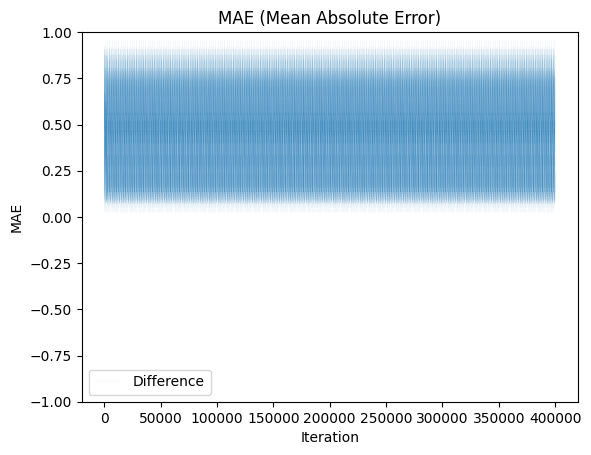

In [ ]:
plt.title("MAE (Mean Absolute Error)")
plt.plot(err_hist, linewidth=0.03, label="Difference")
plt.ylim(-1, 1)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.legend()

In [ ]:
# y_data

In [ ]:
model.stats['jeffress_model.3.sub_module'][-1].shape

KeyError: 'jeffress_model.3.sub_module'